**1. Подготовка данных для обучения модели и обучение YOLOv8**

---


1.1 Установка библеотек и загрузка данных

In [ ]:
!pip install fiftyone ultralytics                                               #Инструмент с открытым исходным кодом для
                                                                                #создания высококачественных наборов
                                                                                #данных и моделей компьютерного зрения

In [ ]:
import numpy as np                                                              #загружаем необходимые для работы кода библеотеки
import os
from tqdm import tqdm
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

In [ ]:
from ultralytics import YOLO                                                    #импортируем архитектуру нейронной сети YOLO
detection_model = YOLO("yolov8s.pt")                                            #импортируем модель детекции YOLOV8 nano, быстро работает, но чаще ошибается
#seg_model = YOLO("yolov8n-seg.pt")                                             #импортируем модель сегментации YOLOV8 nano


In [ ]:
dataset_val = foz.load_zoo_dataset(                                             # загружаем изображения для вилидации из ресурса Openimage
          "open-images-v6",                                                     # версия OpenImage
          split="validation",                                                   # тип разметки датасета "validation" валидации, теста или тренировки
          classes=["Car"],
          only_matching=True,                                                   # классы которые нас интересуют
          label_types=["detections"],                                           # тип решаемой задачи, детекции, сегментации, классификации                  
          max_samples=100          
).map_labels(
    "ground_truth",
    {"Car":"mashina"}
)
###при первом варианте фильтрации и выгрузки dataset_train требуется закоментировать label_types параметр 

dataset_train = foz.load_zoo_dataset(                                           # загрузка изображений и разметки для обучения 
          "open-images-v6",                                                     # далее все тоже самое
          split="train",
          classes=["Car"],
          label_types=["detections"],                                           #<---#label_types
          dataset_name="train_dataset",
          persistent = True,                      
          max_samples=400         
          ).map_labels(
    "ground_truth",
    {"Car":"mashina"}
)

In [ ]:
dataset_train.merge_samples(dataset_val)                                        #Обьединение датасетов для последующей разбивки train и val

In [ ]:
dataset_train.view()                                                            #Просмотр содержимого датасета

1.2 Функция выгрузки данных для обучения модели.

In [ ]:
def export_yolo_data(
    samples, 
    export_dir, 
    #classes, 
    label_field = "ground_truth", 
    split = None
    ):
    if type(split) == list:
        splits = split
        for split in splits:
            export_yolo_data(
                samples, 
                export_dir, 
                #classes, 
                label_field, 
                split
            )   
    else:
        if split is None:
            split_view = samples
            split = "val"
        else:
            split_view = samples.match_tags(split)
        split_view.export(
            export_dir=export_dir,
            dataset_type=fo.types.YOLOv5Dataset,
            label_field=label_field,
            #classes=classes,
            split=split
        )

1.2.1 Первый вариант фильтрации и выгрузки датасета

In [ ]:
import fiftyone.utils.random as four
dataset_train.untag_samples(dataset_train.distinct("tags"))                     # очищаем существующие тэги
four.random_split(                                                              # разбиваем на train и val
    dataset_train,
    {"train": 0.8, "val": 0.2}
)
 

export_yolo_data(                                                               #экспортруем в формат yolo
   dataset_train, 
    "train_dataset", 
    #classes, 
    split = ["train", "val"]
)

1.2.2 Второй вариант фильтрации данных и экспорт в директорию.  И выбор определенного класса для дообучения нейронной сети

---



In [ ]:
data_val = (                                                                    #создаем отфильтрованный датасет 
     dataset_val                                                                #выбираем набор данных для отфильтровывания нужного класса
    .select_fields("ground_truth")                                              #выбираем select_fields поле ground_truth откуда отфильтровываем данные
    .filter_labels("ground_truth", F("label")=="mashina")                       #по этому полю "ground_truth" фильтруем по названию F("label") класса 'Car'
                   #(F("label").is_in (("Person", "Car"))))                     #для выбора для выбора нескольких классов.
    .sort_by(F("ground_truth.detections").length(), reverse=False)              #сортируем разметку sort_by по полю ground_truth.detections
)

data_train = (                                                                  #далее тоже самое
     dataset_train                                                              
    .select_fields("ground_truth")
    .filter_labels("ground_truth", F("label")=="mashina")    
                   #(F("label").is_in (("Person", "Car"))))                     #для выбора для выбора нескольких классов.
    .sort_by(F("ground_truth.detections").length(), reverse=False)
)

In [ ]:
session = fo.launch_app(dataset_train)                                          #Визуализация содержимого отфильтрованного набора данных через приложение fityone

In [ ]:
data_train.view()                                                               #Просмотр информации о содержании датасета

In [ ]:
data_train.export(                                                              #экспортируем информацию из отфильрованного датасета
    export_dir='/content/dataset/train',                                        #директория экспорта
    dataset_type=fo.types.YOLOv5Dataset                                         #формат экспорта у YOLOv5 и YOLOv8 одинаковый формат
) 

data_val.export(                                                                #экспортируем информацию из отфильрованного датасета
    export_dir='/content/dataset/val',                                          #директория экспорта
    dataset_type=fo.types.YOLOv5Dataset                                         #формат экспорта у YOLOv5 и YOLOv8 одинаковый формат
)                                                                               #второй вариант

 100% |█████████████████| 400/400 [2.7s elapsed, 0s remaining, 59.4 samples/s]          


INFO:eta.core.utils: 100% |█████████████████| 400/400 [2.7s elapsed, 0s remaining, 59.4 samples/s]          


 100% |█████████████████| 100/100 [781.8ms elapsed, 0s remaining, 127.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 100/100 [781.8ms elapsed, 0s remaining, 127.9 samples/s]      


In [ ]:
!pip install clearml                                                            #установка среды для сбора статистики

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=8H5AJNHP68DKFIEIQD5P
%env CLEARML_API_SECRET_KEY=Hng61GhKE80vlyRJ1JzNvCjsCo1D11KewqFjyjYnnYuDgz1gEH

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=8H5AJNHP68DKFIEIQD5P
env: CLEARML_API_SECRET_KEY=Hng61GhKE80vlyRJ1JzNvCjsCo1D11KewqFjyjYnnYuDgz1gEH


1.3 Обучение модели YOLOv8

Ниже приведены файлы конфигурации для обучения модели на выгруженных данных, использовать один из двух вариантов, одновременное использование может вызвать ошибку.

1.4.1 создаем файл конфигурации для первого варианта фильтрации и эспорта.

In [ ]:
f = open("detect.yaml", "w+")
f.write("names:\n")
#f.write("- person\n")
f.write("- mashina\n")
f.write("nc: 1\n")
#f.write("nc: 2\n")
f.write("path: /content/train_dataset\n")
f.write("train: ./images/train/\n")
f.write("val: ./images/val/\n")
#f.write("test: /content/detect_yolov/test/images\n")
f.close()

1.4.2 создаем файл конфигурации для второго варианта фильтрации и эспорта

In [ ]:
f = open("detect.yaml", "w+")
f.write("names:\n")
#f.write("- person\n")
f.write("- mashina\n")
f.write("nc: 1\n")
#f.write("nc: 2\n")
f.write("path: /content/dataset\n")
f.write("train: ./train/images/\n")
f.write("val: ./val/images/\n")
#f.write("test: /content/detect_yolov/test/images\n")
f.close()

1.5 запускаем обучение

In [ ]:
from ultralytics import YOLO
 
# Load the model.
model = YOLO('yolov8n.pt')

# Training.
results = model.train(
   data='/content/detect.yaml',
   imgsz=1024,
   epochs=30,
   batch=-1,
   pretrained=False,
   patience=15,
   verbose=True,
   exist_ok=True,
   save_txt=True,
   save_conf=True,
   optimizer='SGD',
   name='yolov8n_v8_50e'
)

гиперпараметры для обучения модели с пояснениями, изначально все настроено  оптимально для обучения, изменение гиперпараметров может привести к замедлению ускорению или не обучению модели.



<tbody>
<tr>
<td><code>model</code></td>
<td><code>None</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">путь к файлу модели, т.е. yolov8n.pt, yolov8n.yaml</font></font></td>
</tr>
<tr>
<td><code>data</code></td>
<td><code>None</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">путь к файлу данных, т.е. coco128.yaml</font></font></td>
</tr>
<tr>
<td><code>epochs</code></td>
<td><code>100</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">количество эпох для обучения</font></font></td>
</tr>
<tr>
<td><code>patience</code></td>
<td><code>50</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">эпохи ожидания отсутствия видимого улучшения для раннего прекращения тренировки</font></font></td>
</tr>
<tr>
<td><code>batch</code></td>
<td><code>16</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">количество изображений в пакете (-1 для AutoBatch)</font></font></td>
</tr>
<tr>
<td><code>imgsz</code></td>
<td><code>640</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">размер входных изображений как целое число или w,h</font></font></td>
</tr>
<tr>
<td><code>save</code></td>
<td><code>True</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">сохранять контрольные точки поезда и прогнозировать результаты</font></font></td>
</tr>
<tr>
<td><code>save_period</code></td>
<td><code>-1</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">Сохранять контрольную точку каждые x эпох (отключено, если &lt; 1)</font></font></td>
</tr>
<tr>
<td><code>cache</code></td>
<td><code>False</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">True/ram, disk или False. </font><font style="vertical-align: inherit;">Использовать кеш для загрузки данных</font></font></td>
</tr>
<tr>
<td><code>device</code></td>
<td><code>None</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">устройство для запуска, например cuda device=0 или device=0,1,2,3 или device=cpu</font></font></td>
</tr>
<tr>
<td><code>workers</code></td>
<td><code>8</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">количество рабочих потоков для загрузки данных (на RANK, если DDP)</font></font></td>
</tr>
<tr>
<td><code>project</code></td>
<td><code>None</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">название проекта</font></font></td>
</tr>
<tr>
<td><code>name</code></td>
<td><code>None</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">название эксперимента</font></font></td>
</tr>
<tr>
<td><code>exist_ok</code></td>
<td><code>False</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">перезаписать ли существующий эксперимент</font></font></td>
</tr>
<tr>
<td><code>pretrained</code></td>
<td><code>False</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">использовать ли предварительно обученную модель</font></font></td>
</tr>
<tr>
<td><code>optimizer</code></td>
<td><code>'SGD'</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">оптимизатор для использования, selections=['SGD', 'Adam', 'AdamW', 'RMSProp']</font></font></td>
</tr>
<tr>
<td><code>verbose</code></td>
<td><code>False</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">следует ли печатать подробный вывод</font></font></td>
</tr>
<tr>
<td><code>seed</code></td>
<td><code>0</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">случайное начальное число для воспроизводимости</font></font></td>
</tr>
<tr>
<td><code>deterministic</code></td>
<td><code>True</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">включить ли детерминированный режим</font></font></td>
</tr>
<tr>
<td><code>single_cls</code></td>
<td><code>False</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">обучать многоклассовые данные как одноклассовые</font></font></td>
</tr>
<tr>
<td><code>image_weights</code></td>
<td><code>False</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">использовать взвешенный выбор изображений для обучения</font></font></td>
</tr>
<tr>
<td><code>rect</code></td>
<td><code>False</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">поддержка прямоугольной тренировки</font></font></td>
</tr>
<tr>
<td><code>cos_lr</code></td>
<td><code>False</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">использовать косинусный планировщик скорости обучения</font></font></td>
</tr>
<tr>
<td><code>close_mosaic</code></td>
<td><code>10</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">отключить увеличение мозаики для последних 10 эпох</font></font></td>
</tr>
<tr>
<td><code>resume</code></td>
<td><code>False</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">возобновить тренировку с последней контрольной точки</font></font></td>
</tr>
<tr>
<td><code>amp</code></td>
<td><code>True</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">Автоматическое обучение смешанной точности (AMP), варианты = [True, False]</font></font></td>
</tr>
<tr>
<td><code>lr0</code></td>
<td><code>0.01</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">начальная скорость обучения (т.е. SGD=1E-2, Adam=1E-3)</font></font></td>
</tr>
<tr>
<td><code>lrf</code></td>
<td><code>0.01</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">окончательная скорость обучения (lr0 * lrf)</font></font></td>
</tr>
<tr>
<td><code>momentum</code></td>
<td><code>0.937</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">Импульс SGD/Adam beta1</font></font></td>
</tr>
<tr>
<td><code>weight_decay</code></td>
<td><code>0.0005</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">уменьшение веса оптимизатора 5e-4</font></font></td>
</tr>
<tr>
<td><code>warmup_epochs</code></td>
<td><code>3.0</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">эпохи прогрева (дробные части в порядке)</font></font></td>
</tr>
<tr>
<td><code>warmup_momentum</code></td>
<td><code>0.8</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">начальный импульс прогрева</font></font></td>
</tr>
<tr>
<td><code>warmup_bias_lr</code></td>
<td><code>0.1</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">начальное смещение прогрева л</font></font></td>
</tr>
<tr>
<td><code>box</code></td>
<td><code>7.5</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">прибыль потери коробки</font></font></td>
</tr>
<tr>
<td><code>cls</code></td>
<td><code>0.5</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">прирост потери cls (масштаб с пикселями)</font></font></td>
</tr>
<tr>
<td><code>dfl</code></td>
<td><code>1.5</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">df убыток прибыль</font></font></td>
</tr>
<tr>
<td><code>fl_gamma</code></td>
<td><code>0.0</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">Гамма фокусных потерь (эффективная гамма по умолчанию = 1,5)</font></font></td>
</tr>
<tr>
<td><code>label_smoothing</code></td>
<td><code>0.0</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">сглаживание меток (доля)</font></font></td>
</tr>
<tr>
<td><code>nbs</code></td>
<td><code>64</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">номинальный размер партии</font></font></td>
</tr>
<tr>
<td><code>overlap_mask</code></td>
<td><code>True</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">маски должны перекрываться во время тренировки (только сегментный train)</font></font></td>
</tr>
<tr>
<td><code>mask_ratio</code></td>
<td><code>4</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">коэффициент понижения маски маски (только train сегмента)</font></font></td>
</tr>
<tr>
<td><code>dropout</code></td>
<td><code>0.0</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">использовать регуляризацию отсева (только классифицировать train)</font></font></td>
</tr>
<tr>
<td><code>val</code></td>
<td><code>True</code></td>
<td><font style="vertical-align: inherit;"><font style="vertical-align: inherit;">проверить/проверить во время обучения</font></font></td>
</tr>
</tbody>


1.6 Проверка работоспособности обученной модели

In [ ]:
import locale                                                                   #Импортруем библеотеку по локализации
locale.getpreferredencoding = lambda: "UTF-8"                                   #Устанавливаем поддержку "UTF-8" чтобы не возникло ошибки
!pip3 install supervision                                                       #Устанавливаем библеотеку

In [ ]:
model.model.names[0]

'mashina'

In [ ]:
!pip install torch torchvision


0: 704x1024 2 mashinas, 20.7ms
Speed: 0.9ms preprocess, 20.7ms inference, 2.3ms postprocess per image at shape (1, 3, 1024, 1024)


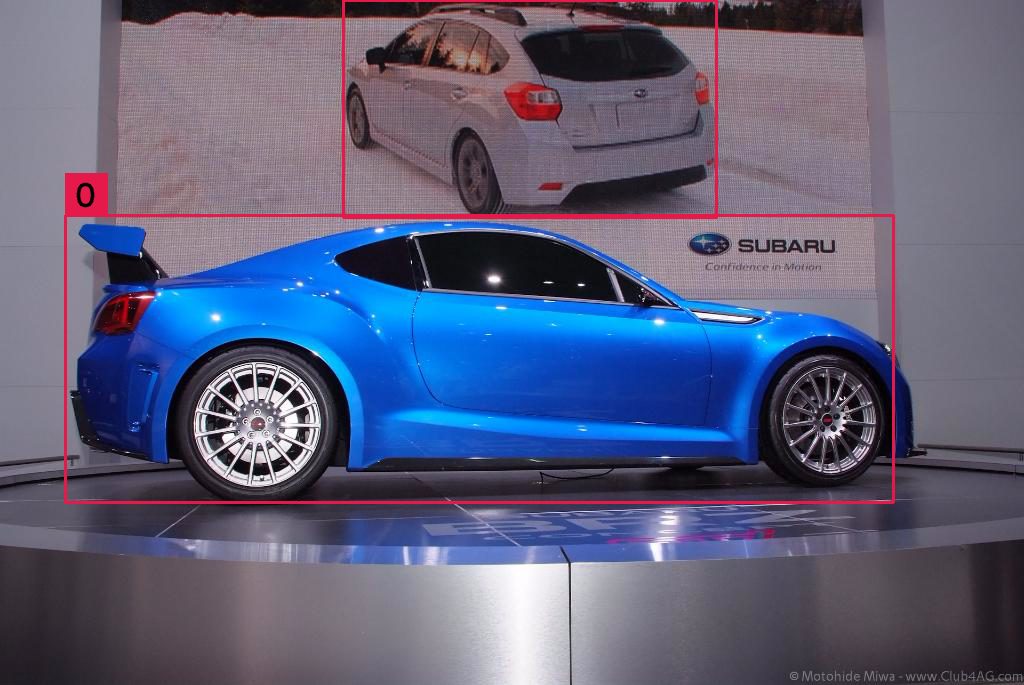

WARNING ⚠️ 'source' is missing. Using 'source=https://ultralytics.com/images/bus.jpg'.

Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/bus.jpg: 1024x768 1 mashina, 29.6ms
Speed: 1.0ms preprocess, 29.6ms inference, 4.2ms postprocess per image at shape (1, 3, 1024, 1024)


AttributeError: ignored

In [ ]:
import cv2
import argparse
from google.colab.patches import cv2_imshow
from ultralytics import YOLO
import supervision as sv

def main():
  cap = cv2.VideoCapture('/content/dataset/train/images/val/0001c8c65851276f.jpg')
  model = YOLO("/content/runs/detect/yolov8n_v8_50e/weights/last.pt")
  box_annotator = sv.BoxAnnotator(
      thickness=2,
      text_thickness=2,
      text_scale=1 
  )

  while True:
    ret,frame = cap.read()
    result = model(frame)[0]
    detections = sv.Detections.from_yolov8(result)
    
    frame = box_annotator.annotate(
        scene=frame,
        detections = detections,
        )

    cv2_imshow(frame)
    if (cv2.waitKey(30) == 27):
      break

if __name__ == "__main__":
    main()


Детекция обьектов Faster R-CNN

---


1.1 Установка библеотек, подготовка данных.

In [1]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [ ]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
!unzip PennFudanPed.zip

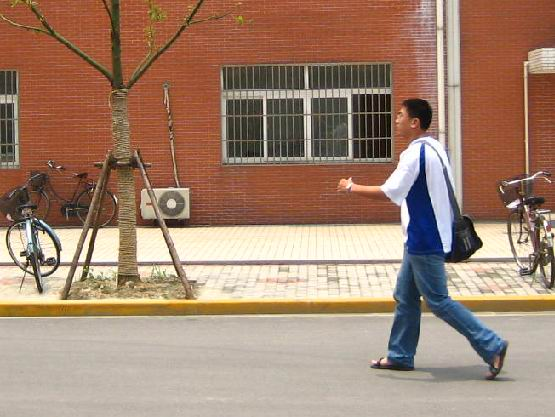

In [3]:
from PIL import Image
Image.open('PennFudanPed/PNGImages/FudanPed00020.png')

In [4]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PedestrianDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

In [22]:
from engine import train_one_epoch, train_one_epoch
import utils
import transforms as T

In [7]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = PedestrianDataset('/content/PennFudanPed', get_transform(train=True))
dataset_test = PedestrianDataset('/content/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 197MB/s]


In [10]:
import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

In [32]:
import torch
import math

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    metric_logger.add_meter('accuracy', utils.SmoothedValue(window_size=1, fmt='{value:.5f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for i, (images, targets) in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Генерация случайных таргетов для каждого объекта в батче
        for i, target in enumerate(targets):
            num_objs = len(target["labels"])
            targets[i]["labels"] = torch.randint(1, num_classes, (num_objs,), device=device)

        # Рассчитываем выход модели и предсказания
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        # Рассчитываем функцию потерь и общую потерю
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Обнуляем градиенты, выполняем обратное распространение и обновляем веса
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Обновляем метрики
        metric_logger.update(loss=losses, **loss_dict)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        metric_logger.update(accuracy=accuracy_meter)

        # Записываем потери для отслеживания
        loss_h.append(loss_dict["loss_classifier"].item())
        box_loss.append(loss_dict["loss_box_reg"].item())
        loss_m.append(loss_dict["loss_mask"].item())

        # Обновляем шедулер и выполняем его шаг
        if lr_scheduler is not None:
            lr_scheduler.step()
        
    return loss_h, box_loss, loss_m
        #loss_history.append(loss_value)
        #lr_history.append(optimizer.param_groups[0]["lr"])
        #return loss_history, lr_history
        

In [ ]:
import matplotlib.pyplot as plt
# колличество эпох
num_classes=2
num_epochs = 10
# Обучение модели и запись результатов в списки
loss_h = []
box_loss=[]
loss_m = []
for epoch in range(num_epochs):
    # Обучение за одну эпоху
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    
 

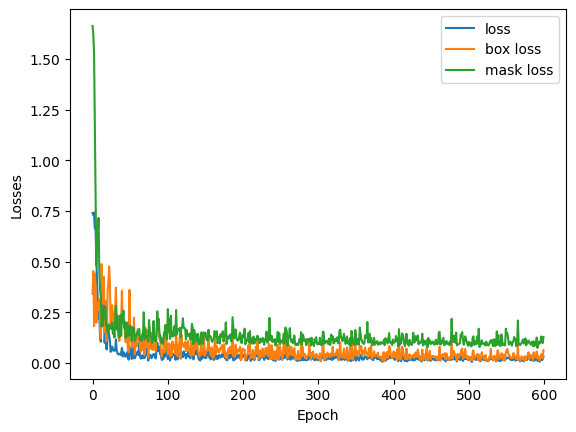

In [17]:
plt.plot(loss_h , label='loss')
plt.plot(box_loss, label='box loss')
plt.plot(loss_m, label='mask loss')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend()
plt.show()

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    losses = []
    accuracies = []
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses.append(loss_dict["loss_classifier"].item())
        #accuracies.append(loss_dict["classification_accuracy"].item())
        optimizer.zero_grad()
        loss_dict["loss_classifier"].backward()
        optimizer.step()
        if i % print_freq == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Batch [{i}/{len(data_loader)}], Loss: {loss_dict['loss_classifier'].item()}")
    return sum(losses)/len(losses)
    

In [ ]:
torch.save(model, 'mask-rcnn-pedestrian.pt')

дообучение модели transfer leraning

In [23]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
loss_h = []
box_loss=[]
loss_m = []

# загрузка предварительно обученной модели Faster R-CNN на COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# замораживаем параметры предварительно обученной модели
for param in model.parameters():
    param.requires_grad = False

# Заменяем классификатор на свой
num_classes = 2  # 1 - для объекта, 1 - для фона                
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Загрузка датасета Penn-Fudan
dataset = PedestrianDataset('/content/PennFudanPed', get_transform(train=True))
dataset_test = PedestrianDataset('/content/PennFudanPed', get_transform(train=False))

# разделение датасета на train и test
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# создание DataLoader-ов для train и test датасетов
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn)

# определение устройства (cpu или gpu)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# перемещение модели на выбранное устройство
model.to(device)

# определение оптимизатора
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# обучение модели
num_epochs = 10
for epoch in range(num_epochs):
    # Обучение за одну эпоху
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # Оценка результатов обучения за одну эпоху
    evaluate(model, data_loader_test, device=device)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    
# сохранение модели
torch.save(model.state_dict(), 'faster_rcnn_trans_lr.pth')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 71.5MB/s]
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker proces

Epoch: [0]  [ 0/60]  eta: 0:19:57  lr: 0.000090  loss: 1.4755 (1.4755)  loss_classifier: 0.8286 (0.8286)  loss_box_reg: 0.6148 (0.6148)  loss_objectness: 0.0156 (0.0156)  loss_rpn_box_reg: 0.0166 (0.0166)  time: 19.9552  data: 0.9724  max mem: 0
Epoch: [0]  [10/60]  eta: 0:12:26  lr: 0.000936  loss: 1.0334 (0.9989)  loss_classifier: 0.5972 (0.5672)  loss_box_reg: 0.3711 (0.3985)  loss_objectness: 0.0225 (0.0276)  loss_rpn_box_reg: 0.0045 (0.0056)  time: 14.9248  data: 0.0943  max mem: 0
Epoch: [0]  [20/60]  eta: 0:10:10  lr: 0.001783  loss: 0.5212 (0.7338)  loss_classifier: 0.2416 (0.3859)  loss_box_reg: 0.2727 (0.3189)  loss_objectness: 0.0187 (0.0244)  loss_rpn_box_reg: 0.0033 (0.0047)  time: 15.0405  data: 0.0092  max mem: 0
Epoch: [0]  [30/60]  eta: 0:07:45  lr: 0.002629  loss: 0.4749 (0.6640)  loss_classifier: 0.2083 (0.3392)  loss_box_reg: 0.2321 (0.2962)  loss_objectness: 0.0187 (0.0237)  loss_rpn_box_reg: 0.0028 (0.0049)  time: 15.8472  data: 0.0112  max mem: 0
Epoch: [0]  [40/

KeyboardInterrupt: ignored

In [ ]:
model.eval()
CLASS_NAMES = ['__background__', 'pedestrian']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)